# 学习率调度器

## LeNet 

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l


def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

# 代码几乎与 `d2l.train_ch6` 定义在卷积神经网络一章LeNet一节中的相同
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

############################################################################ lr-scheduler
        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # Using PyTorch In-Built scheduler
                scheduler.step()
                
            else: # Using custom defined scheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)
############################################################################


    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

C:\Users\11528\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# 固定学习率
## 例如设学习率为$0.3$并训练$30$次迭代。
留意在超过了某点、测试准确度方面的进展停滞时，训练准确度将如何继续提高。
两条曲线之间的间隙表示过拟合。


train loss 0.130, train acc 0.950, test acc 0.896


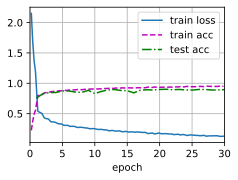

In [2]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

## 学习率：$\eta = \eta_0 (t + 1)^{-\frac{1}{2}}$。

我们可以在每个迭代轮数（甚至在每个小批量）之后向下调整学习率。
例如，以动态的方式来响应优化的进展情况。


In [3]:
lr = 0.1
trainer.param_groups[0]["lr"] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now 0.10


更通常而言，我们应该定义一个调度器。
当调用更新次数时，它将返回学习率的适当值。
让我们定义一个简单的方法，将学习率设置为$\eta = \eta_0 (t + 1)^{-\frac{1}{2}}$。


In [4]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

让我们在一系列值上绘制它的行为。


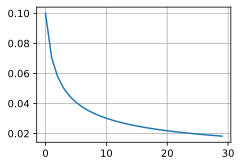

In [5]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

现在让我们来看看这对在Fashion-MNIST数据集上的训练有何影响。
我们只是提供调度器作为训练算法的额外参数。


train loss 0.265, train acc 0.902, test acc 0.871


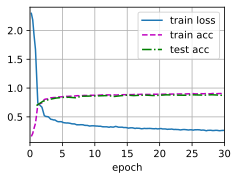

In [6]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, 
##################### !!! here
      scheduler)
#####################
# normal: train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

### 多因子调度器
### 多项式衰减的一种替代方案是乘法衰减，即$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$其中$\alpha \in (0, 1)$。为了防止学习率衰减超出合理的下限，
### 更新方程经常修改为$\eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)$。

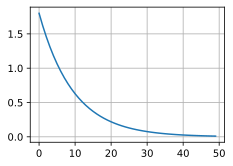

In [7]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

接下来，我们将使用内置的调度器，但在这里仅解释它们的功能。

### 多因子调度器

训练深度网络的常见策略之一是保持分段稳定的学习率，并且每隔一段时间就一定程度学习率降低。
具体地说，  
### 给定一组降低学习率的时间，例如$s = \{5, 10, 20\}$每当$t \in s$时降低$\eta_{t+1} \leftarrow \eta_t \cdot \alpha$。
### 假设每步中的值减半，我们可以按如下方式实现这一点。


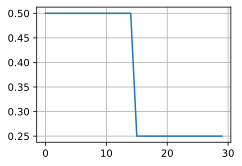

In [8]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler)
                                  for t in range(num_epochs)])

这种分段恒定学习率调度背后的直觉是，让优化持续进行，直到权重向量的分布达到一个驻点。
此时，我们才将学习率降低，以获得更高质量的代理来达到一个良好的局部最小值。
下面的例子展示了如何使用这种方法产生更好的解决方案。


train loss 0.201, train acc 0.924, test acc 0.889


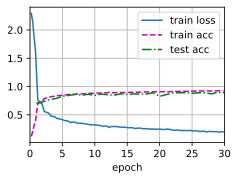

In [9]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### 余弦调度器

余弦调度器是 :cite:`Loshchilov.Hutter.2016`提出的一种启发式算法。  
### 它所依据的观点是：我们可能不想在一开始就太大地降低学习率，而且可能希望最终能用非常小的学习率来“改进”解决方案。
这产生了一个类似于余弦的调度，函数形式如下所示，学习率的值在$t \in [0, T]$之间。

$$\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} \left(1 + \cos(\pi t/T)\right)$$

这里$\eta_0$是初始学习率，$\eta_T$是当$T$时的目标学习率。
此外，对于$t > T$，我们只需将值固定到$\eta_T$而不再增加它。
在下面的示例中，我们设置了最大更新步数$T = 20$。


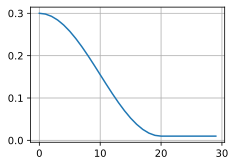

In [10]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

在计算机视觉中，这个调度可以引出改进的结果。
但请注意，如下所示，这种改进并不能保证。


train loss 0.200, train acc 0.927, test acc 0.897


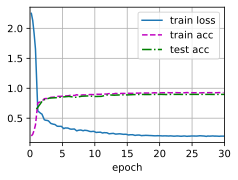

In [11]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

# Warmup

在某些情况下，初始化参数不足以得到良好的解。
这对于某些高级网络设计来说尤其棘手，可能导致不稳定的优化结果。
对此，一方面，我们可以选择一个足够小的学习率，
从而防止一开始发散，然而这样进展太缓慢。
另一方面，较高的学习率最初就会导致发散。

解决这种困境的一个相当简单的解决方法是  
### 使用预热期，在此期间学习率将增加至初始最大值，然后冷却直到优化过程结束。
为了简单起见，通常使用线性递增。
这引出了如下表所示的时间表。


In [12]:
    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

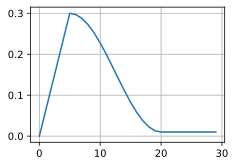

In [13]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

注意，观察前5个迭代轮数的性能，网络最初收敛得更好。


train loss 0.159, train acc 0.942, test acc 0.907


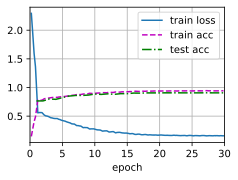

In [14]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

预热可以应用于任何调度器，而不仅仅是余弦。
有关学习率调度的更多实验和更详细讨论，请参阅 :cite:`Gotmare.Keskar.Xiong.ea.2018`。
其中，这篇论文的点睛之笔的发现：预热阶段限制了非常深的网络中参数的发散量。
这在直觉上是有道理的：在网络中那些一开始花费最多时间取得进展的部分，随机初始化会产生巨大的发散。

## 小结

* 在训练期间逐步降低学习率可以提高准确性，并且减少模型的过拟合。
* 在实验中，每当进展趋于稳定时就降低学习率，这是很有效的。从本质上说，这可以确保我们有效地收敛到一个适当的解，也只有这样才能通过降低学习率来减小参数的固有方差。
* 余弦调度器在某些计算机视觉问题中很受欢迎。
* 优化之前的预热期可以防止发散。
* 优化在深度学习中有多种用途。对于同样的训练误差而言，选择不同的优化算法和学习率调度，除了最大限度地减少训练时间，可以导致测试集上不同的泛化和过拟合量。
